
# LangExtract SEO Keyword & Intent Demo (Jupyter Notebook)

This notebook shows how to use **LangExtract** to:
1. **Fetch & extract** SEO keyword suggestions from a competitor article (by URL)
2. **Classify search intent** (Informational / Navigational / Commercial / Transactional) per keyword
3. **Rank keywords**, visualize top terms, and **export to CSV**

> **You need a Gemini API key** to run cloud models. Costs may apply when calling Gemini.


## 0. Setup & Installation

In [21]:

# If you're in a fresh environment, install required packages.
# You can comment this out after the first run.
!pip install -q langextract pandas matplotlib python-dotenv



## 1. Configure API Key & Model

LangExtract looks for `LANGEXTRACT_API_KEY` (or you can pass `api_key=` directly).
We'll also accept `GOOGLE_API_KEY` if that's what you already use.

- Recommended default model: `gemini-2.5-flash`
- For deeper reasoning: `gemini-2.5-pro` (higher cost)


In [24]:

import os
from getpass import getpass
from dotenv import load_dotenv

load_dotenv()

# Priority:
# 1) LANGEXTRACT_API_KEY (already set in env or .env)
# 2) GOOGLE_API_KEY -> mirror into LANGEXTRACT_API_KEY
# 3) Prompt user (hidden input)
api_key = os.getenv("LANGEXTRACT_API_KEY")
if not api_key:
    g_api = os.getenv("GOOGLE_API_KEY")
    if g_api:
        os.environ["LANGEXTRACT_API_KEY"] = g_api
        api_key = g_api

if not api_key:
    os.environ["LANGEXTRACT_API_KEY"] = getpass("Enter your Gemini API key (input hidden): ")
    api_key = os.environ["LANGEXTRACT_API_KEY"]

model_id = "gemini-2.5-flash"  # or "gemini-2.5-pro"
print("Model set to:", model_id)


Model set to: gemini-2.5-flash



## 2. Target Article URL

Change `TARGET_URL` if you want to analyze a different competitor page.


In [27]:

TARGET_URL = "https://newt.net/jpn/tokyo/mag-342975525304"
print("Analyzing URL:", TARGET_URL)


Analyzing URL: https://newt.net/jpn/tokyo/mag-342975525304



## 3. Define Extraction Task (Prompt + Few-shot Examples)

We ask LangExtract to extract **SEO keyword suggestions found in the article text** (2–12 characters/terms),
with **exact source spans** for traceability. We also ask the model to label **intent** and **facet**.


In [29]:

import langextract as lx
import textwrap

prompt = textwrap.dedent("""    あなたはSEOアナリストです。与えられた日本語記事（旅行・チケット系）から、
    競合が実際に本文・見出しの中で使っている「SEOキーワード候補」を抽出してください。

    ルール:
    - extraction_class は必ず "seo_keyword"。
    - extraction_text は **元テキストに実際に出現する日本語のフレーズ**（2〜12 文字程度）。意訳・生成はしない。
    - 抽出順は **出現順**。重複は許容します（後で集計するため）。
    - 各エンティティは **重複しない文字範囲**（span）で指定すること。
    - attributes には以下を含めること:
        - intent: ["informational","navigational","commercial","transactional"] のいずれか
        - facet: 代表カテゴリ（例: "アクセス/行き方","チケット/予約","料金/割引","営業時間/所要時間","注意点/ルール","体験/見どころ" など）
        - hint: 簡単な根拠（例: 「〜という見出し/文脈から意図を判断」）
    - 出力は常にテキストエビデンスに基づくこと（extraction_text は原文の完全一致）。

    注意:
    - 同義語やバリエーションが原文に無い場合は生成しない（extraction_text は原文の正確な文字列のみ）。
    - ブランド名や施設名、地名、行動語（購入・予約・アクセス等）もキーワードになり得る。
    - 改行や見出しをまたいで重複抽出しない。

    目的:
    - 競合記事が狙っているキーワードを可視化し、SEOライターがユーザーの検索意図に合わせて
      自社の記事構成を最適化できるようにする。
""")

# Few-shot example (toy snippet) to teach schema & attributes
example_text = "【東京ハリー・ポッター スタジオツアー】チケットの買い方・アクセス・所要時間を解説。割引や当日券はある？"
example = lx.data.ExampleData(
    text=example_text,
    extractions=[
        lx.data.Extraction(
            extraction_class="seo_keyword",
            extraction_text="チケット",
            attributes={"intent":"transactional","facet":"チケット/予約","hint":"購入・予約に関する語"}
        ),
        lx.data.Extraction(
            extraction_class="seo_keyword",
            extraction_text="アクセス",
            attributes={"intent":"informational","facet":"アクセス/行き方","hint":"行き方の説明に関する語"}
        ),
        lx.data.Extraction(
            extraction_class="seo_keyword",
            extraction_text="所要時間",
            attributes={"intent":"informational","facet":"営業時間/所要時間","hint":"滞在時間の目安"}
        ),
        lx.data.Extraction(
            extraction_class="seo_keyword",
            extraction_text="割引",
            attributes={"intent":"commercial","facet":"料金/割引","hint":"価格・お得情報"}
        ),
        lx.data.Extraction(
            extraction_class="seo_keyword",
            extraction_text="当日券",
            attributes={"intent":"transactional","facet":"チケット/予約","hint":"当日購入可否"}
        ),
    ]
)
examples = [example]
print("Example ready.")


Example ready.


In [35]:
!pip install -q beautifulsoup4 lxml requests

import re, requests, bs4

def fetch_main_text_bs(url: str) -> str:
    headers = {
        "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 "
                      "(KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36"
    }
    resp = requests.get(url, timeout=30, headers=headers)
    resp.raise_for_status()

    # ✅ 用 bytes，交給 BS4/lxml 自動偵測（會讀 <meta charset>）
    html_bytes = resp.content
    soup = bs4.BeautifulSoup(html_bytes, "lxml")

    # （以下同你原本流程）移除無用區塊
    for bad in soup(["script","style","noscript","svg"]):
        bad.decompose()
    for sel in [
        ".breadcrumbs",".share",".sns",".social",".related",".recommend",
        ".footer",".site-footer",".author",".profile",".tagcloud",
        ".advertisement",".ads",".promo",".newsletter",".cookie",".consent"
    ]:
        for n in soup.select(sel):
            n.decompose()

    candidates = [
        "article",
        '[role="main"]',
        ".entry-content",
        ".article-body",
        ".post-content",
        ".content__body",
        ".main-contents",
        "#main article",
        ".Article__Body", ".article__content", ".single-content"
    ]
    text = ""
    for sel in candidates:
        node = soup.select_one(sel)
        if node and node.get_text(strip=True):
            text = node.get_text("\n", strip=True)
            break

    if not text:
        text = soup.get_text("\n", strip=True)

    lines = [ln.strip() for ln in text.splitlines()]
    lines = [ln for ln in lines if len(ln) >= 2]
    text = "\n".join(lines)
    text = re.sub(r"\n{3,}", "\n\n", text)
    return text


clean_text = fetch_main_text_bs(TARGET_URL)
print("Main-text length:", len(clean_text))
print(clean_text[:400])


Main-text length: 5458
アジア
日本
東京
ハリーポッター としまえんへのアクセス！最安・最速の行き方をご紹介！
スタジオツアー東京（ハリーポッター としまえん）は、東京駅から電車で約45分で行ける場所。ハリーポッターの世界観や舞台裏をたっぷり堪能できる人気の観光スポットです。本記事では、スタジオツアー東京に行く方法をご紹介。電車や車（タクシー）などさまざまな方法があるので、自分の目的にぴったりの移動手段を選んでくださいね。
2024年12月2日
ライター
NEWT編集部
NEWT編集部による海外旅行に関する最新情報やおトク情報を続々配信しています！メンバーが実際に行った国や都市、スポットなどの情報をどこよりも詳しくご紹介！
スタジオツアー東京（ハリーポッター としまえん）は、東京駅から電車で約45分で行ける場所。ハリーポッターの世界観や舞台裏をたっぷり堪能できる人気の観光スポットです。
本記事では、スタジオツア



## 4. Run Extraction

We process the URL directly. For longer pages, we use chunking + parallelism for quality & speed.


In [ ]:

result = lx.extract(
    text_or_documents=clean_text,
    prompt_description=prompt,
    examples=examples,
    model_id=model_id,
    extraction_passes=2,     # Multiple passes to improve recall
    max_workers=8,           # Parallel chunks for speed
    max_char_buffer=1200     # Smaller contexts help precision
)
len(result.extractions), len(result.text)


2025-08-25 22:50:54,348 - langextract.debug - DEBUG - [langextract.inference] CALL: BaseLanguageModel.__init__(self=<GeminiLanguageModel>, constraint=Constraint(co...NONE: 'none'>), kwargs={})
2025-08-25 22:50:54,348 - langextract.debug - DEBUG - [langextract.inference] RETURN: BaseLanguageModel.__init__ -> None (0.0 ms)
2025-08-25 22:50:54,348 - langextract.debug - DEBUG - [langextract.inference] CALL: BaseLanguageModel.apply_schema(self=<GeminiLanguageModel>, schema_instance=GeminiSchema(...xtractions']}))
2025-08-25 22:50:54,348 - langextract.debug - DEBUG - [langextract.inference] RETURN: BaseLanguageModel.apply_schema -> None (0.0 ms)
DEBUG:absl:Initialized Annotator with prompt:
あなたはSEOアナリストです。与えられた日本語記事（旅行・チケット系）から、
競合が実際に本文・見出しの中で使っている「SEOキーワード候補」を抽出してください。

ルール:
- extraction_class は必ず "seo_keyword"。
- extraction_text は **元テキストに実際に出現する日本語のフレーズ**（2〜12 文字程度）。意訳・生成はしない。
- 抽出順は **出現順**。重複は許容します（後で集計するため）。
- 各エンティティは **重複しない文字範囲**（span）で指定すること。
- attributes には以下を含めること:
    - intent:

✓ Extraction processing complete



INFO:absl:Finalizing annotation for document ID doc_568203f5.
INFO:absl:Document annotation completed.
INFO:absl:Starting extraction pass 2 of 2
INFO:absl:Starting document annotation.
INFO:absl:Processing batch 0 with length 5
DEBUG:absl:Token util returns string: アジア
日本
東京
ハリーポッター としまえんへのアクセス！最安・最速の行き方をご紹介！
スタジオツアー東京（ハリーポッター としまえん）は、東京駅から電車で約45分で行ける場所。ハリーポッターの世界観や舞台裏をたっぷり堪能できる人気の観光スポットです。本記事では、スタジオツアー東京に行く方法をご紹介。電車や車（タクシー）などさまざまな方法があるので、自分の目的にぴったりの移動手段を選んでくださいね。
2024年12月2日
ライター
NEWT編集部
NEWT編集部による海外旅行に関する最新情報やおトク情報を続々配信しています！メンバーが実際に行った国や都市、スポットなどの情報をどこよりも詳しくご紹介！
スタジオツアー東京（ハリーポッター としまえん）は、東京駅から電車で約45分で行ける場所。ハリーポッターの世界観や舞台裏をたっぷり堪能できる人気の観光スポットです。
本記事では、スタジオツアー東京に行く方法をご紹介。電車や車（タクシー）などさまざまな方法があるので、自分の目的にぴったりの移動手段を選んでくださいね。
Contents
スタジオツアー東京に行く方法は？距離は？
スタジオツアー東京とは？チケット購入の方法は？
スタジオツアー東京までの最速・最安の行き方は？
スタジオツアー東京まで電車でアクセス！
最寄駅から徒歩2分でアクセスでき、1番おすすめ
スタジオツアー東京までの金額は乗車する駅によって異なる
もっとみる
＼NEWTでおトクに旅行しませんか✈️／
NEWTでツアーをみる
スタジオツアー東京に行く方法は？距離は？
Warner Bros. Studio Tour Tokyo - The Making of Harry Potter


## 5. Save JSONL & Generate Interactive HTML (Traceable Evidence)

Open the HTML to audit spans, filter by `intent`/`facet`, and jump to source contexts.


In [ ]:

lx.io.save_annotated_documents([result], output_name="seo_keywords.jsonl", output_dir=".")

html_content = lx.visualize("seo_keywords.jsonl")
with open("seo_keywords_visualization.html", "w", encoding="utf-8") as f:
    if hasattr(html_content, 'data'):
        f.write(html_content.data)   # Jupyter/Colab
    else:
        f.write(html_content)        # Standard Python

print("Saved: seo_keywords.jsonl / seo_keywords_visualization.html")



## 6. Aggregate & Rank Keywords

We group exact phrases (`extraction_text`) and compute simple frequency counts in the full text.
(You can extend this with Japanese tokenization/lemmatization if desired.)


In [40]:

import pandas as pd

# Keep only seo_keyword class
records = []
for e in result.extractions:
    if e.extraction_class == "seo_keyword":
        s = getattr(e, "char_interval", None)
        start, end = (None, None)
        if s:
            start, end = s.start_pos, s.end_pos
        attrs = e.attributes or {}
        records.append({
            "keyword": e.extraction_text,
            "intent": attrs.get("intent"),
            "facet": attrs.get("facet"),
            "hint": attrs.get("hint"),
            "start": start, "end": end
        })

df = pd.DataFrame(records)
if df.empty:
    print("No seo_keyword extracted. Try increasing extraction_passes, or switching model to gemini-2.5-pro.")
else:
    # Count unique phrases in the document (exact-match occurrences)
    full_text = result.text
    counts = (
        df.groupby(["keyword","intent","facet"], dropna=False)
          .size()
          .reset_index(name="mentions_extracted")
    )
    # crude total occurrences by substring count
    def count_occurrences(text, phrase):
        return text.count(phrase) if isinstance(phrase, str) else 0

    counts["occurrences_in_text"] = counts["keyword"].apply(lambda k: count_occurrences(full_text, k))

    # Simple priority score (you can refine this)
    # score = 2 * mentions_extracted + occurrences_in_text
    counts["score"] = 2 * counts["mentions_extracted"] + counts["occurrences_in_text"]

    counts = counts.sort_values(["score","occurrences_in_text","mentions_extracted"], ascending=False)
    display(counts.head(30))


,keyword,intent,facet,mentions_extracted,occurrences_in_text,score
12,スタジオツアー東京,navigational,施設名,57,45,159
121,豊島園駅,navigational,アクセス/行き方,25,20,70
7,アクセス,informational,アクセス/行き方,23,22,68
134,電車,informational,アクセス/行き方,23,21,67
126,車,informational,アクセス/行き方,4,54,62
24,ツアー,transactional,チケット/予約,2,47,51
11,スタジオツアー東京,navigational,体験/見どころ,1,45,47
97,移動,informational,アクセス/行き方,10,24,44
15,タクシー,informational,アクセス/行き方,9,19,37
117,西武池袋線,informational,アクセス/行き方,12,10,34



## 7. Visualize Top Keywords


In [50]:
import matplotlib.pyplot as plt
from matplotlib import font_manager, rcParams

# 常見日文字型清單（依序嘗試）
jp_fonts = [
    "Noto Sans CJK JP", "Noto Sans JP", "Noto Serif JP",
    "Hiragino Sans", "Hiragino Kaku Gothic ProN",
    "Yu Gothic", "Meiryo",
    "MS Gothic", "MS Mincho",
    "IPAexGothic", "IPAPGothic", "TakaoGothic",
]

available = {f.name for f in font_manager.fontManager.ttflist}
picked = None
for name in jp_fonts:
    if name in available:
        rcParams["font.family"] = name
        picked = name
        break

rcParams["axes.unicode_minus"] = False  # 讓負號也能正確顯示
print("Using font:", picked or "＜未找到日文字型，請先安裝＞")


Using font: Hiragino Sans


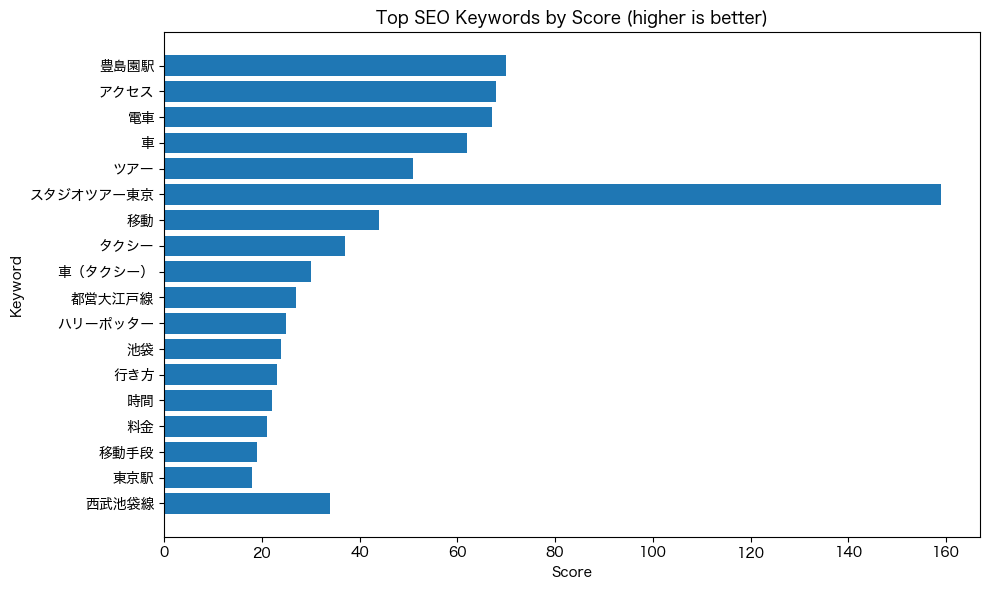

In [52]:

import matplotlib.pyplot as plt

if 'counts' in globals() and not counts.empty:
    top = counts.head(20)
    plt.figure(figsize=(10, 6))
    plt.barh(top["keyword"][::-1], top["score"][::-1])
    plt.title("Top SEO Keywords by Score (higher is better)")
    plt.xlabel("Score")
    plt.ylabel("Keyword")
    plt.tight_layout()
    plt.show()
else:
    print("Nothing to plot.")



## 8. Export for Writers/Stakeholders


In [44]:

if 'counts' in globals() and not counts.empty:
    counts.to_csv("seo_keywords_ranked.csv", index=False)
    print("Saved seo_keywords_ranked.csv")
else:
    print("No data to export.")


Saved seo_keywords_ranked.csv



## 9. User Query Needs Summary (Intent → Facet → Keywords)

Quick roll-up so writers can plan the outline to match search intent.


In [58]:
import pandas as pd

if 'counts' in globals() and isinstance(counts, pd.DataFrame) and not counts.empty:
    intent_order = ["transactional","commercial","informational","navigational"]

    # keyword 正規化成 string，移除 NaN/空白
    counts = counts.copy()
    counts["keyword"] = (
        counts["keyword"].astype("string").fillna("").str.strip()
    )
    counts = counts[counts["keyword"] != ""]  # 丟掉空的

    # intent 清洗：未知的設為 "informational"（可改成你要的預設）
    counts["intent"] = counts["intent"].where(counts["intent"].isin(intent_order), "informational")
    counts["intent"] = pd.Categorical(counts["intent"], categories=intent_order, ordered=True)  # ✅ 注意這行

    # 聚合用：回傳純字串去重清單
    def uniq_str_list(series: pd.Series):
        seen = {}
        for x in series:
            if isinstance(x, str):
                s = x.strip()
                if s:
                    seen.setdefault(s, True)
        return list(seen.keys())[:10]

    grouped = (
        counts.groupby(["intent","facet"], dropna=False)
              .agg({"keyword": uniq_str_list, "score": "sum"})
              .reset_index()
              .sort_values(["intent","score"], ascending=[True, False])
    )

    display(grouped)

    print("Suggested Outline (Draft)")
    for intent in intent_order:
        sub = grouped[grouped["intent"] == intent]
        if sub.empty:
            continue
        print(f"\n# Intent: {intent}")
        for _, row in sub.iterrows():
            facet = row["facet"] if pd.notna(row["facet"]) else "その他"
            kws_list = row["keyword"] if isinstance(row["keyword"], list) else []
            kws = "、".join(kws_list[:6]) if kws_list else "（該当なし）"
            print(f"- {facet}: {kws}")
else:
    print("No aggregated data available.")


/var/folders/h8/tsvm04j506gbcjxw2cl7_k580000gn/T/ipykernel_54424/4116493210.py:28: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts.groupby(["intent","facet"], dropna=False)


,intent,facet,keyword,score
2,transactional,チケット/予約,"[ツアー, チケット購入, 予約, チケット, 購入, スタジオツアー東京のチケット, チケ...",107
0,transactional,アクセス/行き方,[タクシー配車アプリ],3
1,transactional,サービス名,NaN,0
3,transactional,体験/見どころ,NaN,0
4,transactional,作品名,NaN,0
5,transactional,営業時間/所要時間,NaN,0
6,transactional,地名/駅名,NaN,0
7,transactional,料金/割引,NaN,0
8,transactional,施設の種類,NaN,0
9,transactional,施設タイプ,NaN,0


Suggested Outline (Draft)

# Intent: transactional
- チケット/予約: ツアー、チケット購入、予約、チケット、購入、スタジオツアー東京のチケット
- アクセス/行き方: タクシー配車アプリ
- サービス名: （該当なし）
- 体験/見どころ: （該当なし）
- 作品名: （該当なし）
- 営業時間/所要時間: （該当なし）
- 地名/駅名: （該当なし）
- 料金/割引: （該当なし）
- 施設の種類: （該当なし）
- 施設タイプ: （該当なし）
- 施設利用/予約: （該当なし）
- 施設名: （該当なし）
- 施設情報: （該当なし）
- 比較/評価: （該当なし）
- 注意点/ルール: （該当なし）

# Intent: commercial
- 料金/割引: 料金、金額、最安、駐車料金、280円、おトクに旅行
- チケット/予約: 正規代理店
- アクセス/行き方: （該当なし）
- サービス名: （該当なし）
- 体験/見どころ: （該当なし）
- 作品名: （該当なし）
- 営業時間/所要時間: （該当なし）
- 地名/駅名: （該当なし）
- 施設の種類: （該当なし）
- 施設タイプ: （該当なし）
- 施設利用/予約: （該当なし）
- 施設名: （該当なし）
- 施設情報: （該当なし）
- 比較/評価: （該当なし）
- 注意点/ルール: （該当なし）

# Intent: informational
- アクセス/行き方: アクセス、電車、車、移動、タクシー、西武池袋線
- 営業時間/所要時間: 時間、所要時間、約45分、約50分、運行本数、約30分
- 体験/見どころ: ハリーポッター、観光、ハリーポッターの世界観、おすすめな人、日帰り、エンターテイメント施設
- 注意点/ルール: メリット、荷物、混雑、デメリット、大きな荷物、電車がかなり混雑
- 比較/評価: メリット＆デメリット、メリット・デメリット
- 施設タイプ: 観光スポット
- 施設利用/予約: 事前予約
- チケット/予約: チケットは売り切れ
- 料金/割引: 料金が高い
- 施設の種類: エンターテイメント施設
- 施設情報: 改札口
- サービス名: （該当なし）
- 作品名: （該当なし）
- 地名/駅名: （該当

In [60]:
# 安裝新版 Gemini SDK（若環境已含則會跳過）
!pip install -q google-genai || pip install -q google-generativeai

import os, json, re
import pandas as pd

# 1) 讀 CSV
csv_path = "seo_keywords_ranked.csv"
if not os.path.exists(csv_path):
    raise FileNotFoundError(f"找不到 {csv_path}，請先執行前面步驟產生 CSV。")

counts = pd.read_csv(csv_path)

# 2) 清洗與挑選「5個重要キーワード」
# - 去空白與無效
counts["keyword"] = counts["keyword"].astype("string").fillna("").str.strip()
counts = counts[counts["keyword"] != ""]
# - 依 score 排序（已在前面算好）
counts = counts.sort_values(["score","occurrences_in_text","mentions_extracted"], ascending=False)

# - 盡量多樣化各意圖 (transactional, commercial, informational, navigational)
intent_order = ["transactional","commercial","informational","navigational"]
counts["intent"] = counts["intent"].where(counts["intent"].isin(intent_order), "informational")

# （可選）過濾純數字/金額之類過泛詞
def plausible_kw(s: str) -> bool:
    if not isinstance(s, str) or not s.strip():
        return False
    # 只含數字/貨幣/百分比的，過濾掉
    if re.fullmatch(r"[\d,\.円¥%]+", s):
        return False
    return True
counts = counts[counts["keyword"].apply(plausible_kw)]

# - 每個 intent 先挑 top 2，再用整體高分補齊到 5
picked = []
seen = set()
for intent in intent_order:
    sub = counts[counts["intent"] == intent].head(2)
    for _, row in sub.iterrows():
        k = row["keyword"]
        key = (k, row["intent"], str(row.get("facet", "")))
        if k and key not in seen:
            picked.append(row)
            seen.add(key)

# 若不足 5 個，從全體最高分往下補
if len(picked) < 5:
    for _, row in counts.itertuples(index=False, name="r")._asdict().items():
        pass  # just to help autocomplete in some IDEs

for _, row in counts.iterrows():
    if len(picked) >= 5:
        break
    key = (row["keyword"], row["intent"], str(row.get("facet", "")))
    if key not in seen:
        picked.append(row)
        seen.add(key)

top5_df = pd.DataFrame(picked)[:5][["keyword","intent","facet","score","occurrences_in_text","mentions_extracted"]].reset_index(drop=True)
print("★ 選出的 5 個キーワード候補")
display(top5_df)

# 3) 準備給 Gemini 的「情境 JSON」
context_rows = counts.head(40)[["keyword","intent","facet","score","occurrences_in_text","mentions_extracted"]]
context_json = context_rows.to_dict(orient="records")
top5_json = top5_df.to_dict(orient="records")

# 4) 組裝提示（日本語出力 + 結構化 JSON）
MODEL_ID = os.getenv("MODEL_ID", "gemini-2.5-flash")
API_KEY = os.getenv("LANGEXTRACT_API_KEY") or os.getenv("GOOGLE_API_KEY")
if not API_KEY:
    raise EnvironmentError("請先設定 LANGEXTRACT_API_KEY 或 GOOGLE_API_KEY 環境變數。")

prompt = f"""
あなたは上級SEO編集長です。入力の上位キーワード候補（score順）と、抽出済みの5つの重要候補を踏まえ、
以下をすべて**日本語**で出力してください。出力は**有効なJSONのみ**。

要件:
1) "top5" 配列（長さ5）：各要素は
   - keyword: string
   - intent: one of ["transactional","commercial","informational","navigational"]
   - facet: string
   - user_need: そのキーワードでユーザーが検索する背景ニーズ（なぜ検索？何を解決したい？）
   - content_angle: 記事での打ち出し方（差別化や価値提案）
   - section_outline: そのキーワードに対応する小見出し/要点（2〜5項目の配列）
   - cta: 適切なCTA案（例: 予約/比較/地図案内/公式サイト誘導 など）

2) "writing_advice" オブジェクト（記事全体の方針）：
   - title_options: 記事タイトル案（3案、配列）
   - meta_description: 120字程度
   - h2_outline: 推奨H2構成（5〜8項目の配列）
   - faqs: よくある質問（2〜5項目の配列、それぞれ簡潔な回答を含む "Q: ... / A: ..." 形式の文字列）
   - cta_suggestions: 全体で使えるCTA（配列）
   - notes: 執筆上の注意（配列、トーン/NG/固有名詞の扱いなど）

制約:
- JSON以外の文字を一切出さない（前後文やMarkdown記法なし）
- "keyword" は入力のキーワードそのものを使う（生成・言い換えしない）

入力（上位候補の要約・最大40件）:
{json.dumps(context_json, ensure_ascii=False, indent=2)}

入力（重要候補5件／優先検討対象）:
{json.dumps(top5_json, ensure_ascii=False, indent=2)}
"""

# 5) 呼叫 Gemini（優先使用 google-genai；不行就退回舊版 google.generativeai）
def call_gemini(prompt: str, model_id: str, api_key: str) -> str:
    try:
        # 新版 SDK
        from google import genai
        client = genai.Client(api_key=api_key)
        # 新版常用接口
        try:
            resp = client.models.generate_content(model=model_id, contents=prompt)
            text = getattr(resp, "output_text", None) or getattr(resp, "text", None)
        except Exception:
            # 部分版本是 client.responses.generate
            resp = client.responses.generate(model=model_id, input=prompt)
            text = getattr(resp, "output_text", None) or getattr(resp, "text", None)
        if not text:
            # 嘗試從 candidates 結構取
            cand0 = getattr(resp, "candidates", [None])[0]
            if cand0 and getattr(cand0, "content", None) and getattr(cand0.content, "parts", None):
                text = cand0.content.parts[0].text
        if not text:
            raise RuntimeError("Empty response from google-genai")
        return text
    except Exception:
        # 舊版 SDK
        import google.generativeai as genai_legacy
        genai_legacy.configure(api_key=api_key)
        model = genai_legacy.GenerativeModel(model_id)
        resp = model.generate_content(prompt)
        text = getattr(resp, "text", None)
        if not text:
            raise RuntimeError("Empty response from google.generativeai")
        return text

raw = call_gemini(prompt, MODEL_ID, API_KEY)

# 6) 解析 JSON（容錯：去掉可能的 ```json 標記等）
def extract_json(s: str) -> dict:
    s = s.strip()
    # 移除 Markdown code fence
    s = re.sub(r"^```(?:json)?\s*|\s*```$", "", s, flags=re.DOTALL)
    # 嘗試直接 parse
    try:
        return json.loads(s)
    except json.JSONDecodeError:
        # 寬鬆處理：抓第一個完整的大括號塊
        m = re.search(r"\{.*\}", s, flags=re.DOTALL)
        if not m:
            raise
        return json.loads(m.group(0))

data = extract_json(raw)

# 7) 友善顯示 & 存檔
print("=== Top 5 キーワードとユーザーニーズ ===")
top5 = data.get("top5", [])
for i, item in enumerate(top5, 1):
    print(f"\n[{i}] {item.get('keyword')}  ({item.get('intent')}/{item.get('facet')})")
    print("  ・ユーザーニーズ:", item.get("user_need"))
    print("  ・コンテンツ角度:", item.get("content_angle"))
    outline = item.get("section_outline") or []
    if outline:
        print("  ・対応セクション案:")
        for h in outline:
            print("    -", h)
    if item.get("cta"):
        print("  ・CTA:", item.get("cta"))

print("\n=== 全体の執筆アドバイス ===")
adv = data.get("writing_advice", {})
if adv:
    if adv.get("title_options"):
        print("\n・タイトル案:")
        for t in adv["title_options"]:
            print("  -", t)
    if adv.get("meta_description"):
        print("\n・メタディスクリプション:\n ", adv["meta_description"])
    if adv.get("h2_outline"):
        print("\n・推奨H2構成:")
        for h in adv["h2_outline"]:
            print("  -", h)
    if adv.get("faqs"):
        print("\n・FAQ:")
        for q in adv["faqs"]:
            print("  -", q)
    if adv.get("cta_suggestions"):
        print("\n・CTA案:")
        for c in adv["cta_suggestions"]:
            print("  -", c)
    if adv.get("notes"):
        print("\n・注意点:")
        for n in adv["notes"]:
            print("  -", n)

# 存檔（JSON）
with open("seo_suggestions.json", "w", encoding="utf-8") as f:
    json.dump(data, f, ensure_ascii=False, indent=2)

print("\nSaved: seo_suggestions.json")


★ 選出的 5 個キーワード候補


,keyword,intent,facet,score,occurrences_in_text,mentions_extracted
0,ツアー,transactional,チケット/予約,51,47,2
1,チケット購入,transactional,チケット/予約,15,3,6
2,料金,commercial,料金/割引,21,9,6
3,金額,commercial,料金/割引,15,3,6
4,アクセス,informational,アクセス/行き方,68,22,23


=== Top 5 キーワードとユーザーニーズ ===

[1] スタジオツアー東京  (navigational/施設名)
  ・ユーザーニーズ: 施設自体の情報、概要、見どころ、特徴を知りたい。漠然とした興味から具体的な検討段階へ進みたい。
  ・コンテンツ角度: 施設全体の魅力を俯瞰し、訪問の動機付けとなるような情報を網羅的に提供。ハリー・ポッターの世界観を最大限に伝える。
  ・対応セクション案:
    - ワーナー ブラザース スタジオツアー東京とは？
    - ハリー・ポッターの世界を体験できる3つの魔法のポイント
    - 混雑を避けるためのベストシーズンと時間帯
    - 最新情報＆イベントカレンダー
  ・CTA: 公式サイトでスタジオツアー東京の全貌を見る

[2] アクセス  (informational/アクセス/行き方)
  ・ユーザーニーズ: スタジオツアー東京への最適な交通手段や所要時間、経路を知りたい。迷わずに現地に到着したい。
  ・コンテンツ角度: 主要な出発地（東京駅、池袋、新宿など）からのアクセス方法を網羅し、移動時間や費用、乗り換えの分かりやすさなどを比較検討できる情報を提供。
  ・対応セクション案:
    - スタジオツアー東京への主要な交通手段一覧
    - 電車でのアクセス：各路線（西武池袋線、都営大江戸線）詳細ガイド
    - 車でのアクセス：駐車場情報と周辺の道路状況
    - バス・タクシー利用のポイントと注意点
    - 豊島園駅からの最終ルート案内
  ・CTA: Googleマップで最新の経路を検索する

[3] 料金  (commercial/料金/割引)
  ・ユーザーニーズ: 入場料や追加料金、割引情報、お得なチケットについて知りたい。予算を把握し、費用を抑える方法を検討したい。
  ・コンテンツ角度: 基本料金だけでなく、年齢別料金、団体割引、周辺施設とのセット券など、様々な料金プランを比較提示し、ユーザーに最適な選択肢を提案。隠れた費用についても言及。
  ・対応セクション案:
    - スタジオツアー東京の基本入場料金（大人・中高生・子ども）
    - お得な割引情報や期間限定キャンペーン
    - チケットの種類と選び方（日時指定券の重要性）
    - 料金に含まれ

In [62]:
# If you haven't installed the Gemini SDK in this environment yet:
!pip install -q google-generativeai

import os, json, math, textwrap
import pandas as pd
import google.generativeai as genai

# --- Load your ranked keywords ---
CSV_PATH = "seo_keywords_ranked.csv"
if not os.path.exists(CSV_PATH):
    raise FileNotFoundError(f"CSV not found: {CSV_PATH}. Please run the earlier cells to create it.")

counts = pd.read_csv(CSV_PATH)

# Basic cleaning / safety
for col in ["keyword","intent","facet"]:
    if col in counts.columns:
        counts[col] = counts[col].astype("string").fillna("").str.strip()

# Optional: keep only plausible non-empty keywords
counts = counts[counts["keyword"] != ""].copy()

# Summary slices to feed model (you can adjust N to control cost/context length)
N_CONTEXT = 120  # how many rows to summarize into model context
counts_sorted = counts.sort_values(["score","occurrences_in_text","mentions_extracted"], ascending=False)
context_rows = counts_sorted.head(N_CONTEXT).copy()

# Small human-readable context lines for the LLM
def row_to_line(r):
    kw   = r.get("keyword", "")
    it   = r.get("intent", "") or "informational"
    fac  = r.get("facet", "") or "—"
    sc   = int(r.get("score", 0))
    occ  = int(r.get("occurrences_in_text", 0))
    mext = int(r.get("mentions_extracted", 0))
    return f"KW={kw} | intent={it} | facet={fac} | score={sc} | occ={occ} | mentions={mext}"

context_lines = [row_to_line(r) for _, r in context_rows.iterrows()]
context_text  = "\n".join(context_lines)

# Some quick numeric summaries (optional, also passed to the model)
intent_mix = (
    counts.assign(intent=counts["intent"].where(counts["intent"].isin(
        ["transactional","commercial","informational","navigational"]
    ), "informational"))
    .groupby("intent")["score"].sum()
    .sort_values(ascending=False)
    .to_dict()
)

facet_mix = (
    counts.groupby("facet", dropna=False)["score"].sum()
    .sort_values(ascending=False)
    .head(15)
    .to_dict()
)

# --- Configure Gemini ---
api_key = os.getenv("LANGEXTRACT_API_KEY") or os.getenv("GOOGLE_API_KEY")
if not api_key:
    raise RuntimeError("Missing API key. Set LANGEXTRACT_API_KEY or GOOGLE_API_KEY.")

genai.configure(api_key=api_key)
GEMINI_MODEL_FOR_ANALYSIS = "gemini-2.5-pro"   # You can switch to gemini-2.5-flash for cheaper runs

generation_config = {
    "temperature": 0.5,
    "top_p": 0.95,
    "response_mime_type": "application/json",  # ask for JSON so we can parse reliably
}

model = genai.GenerativeModel(GEMINI_MODEL_FOR_ANALYSIS, generation_config=generation_config)

# --- Compose the instruction for the strategy & top-5 keywords ---
# The prompt is in Japanese to match your content & output needs.
instruction = textwrap.dedent(f"""
あなたは上級SEOストラテジストです。以下の「抽出済みキーワード・意図・スコアの一覧」を総合的に分析し、
(1) 類似記事を制作するライター向けの実践的な執筆ガイド
(2) 最重要の「キーワードサジェスト 5件」と、それぞれの背後にあるユーザーニーズ
を日本語で出力してください。

前提:
- 対象は旅行・チケット系の日本語記事。
- 入力のキーワードはすべて本文由来の「原文一致フレーズ」で、intent は
  ["informational","navigational","commercial","transactional"] のいずれか。
- facet はテーマの切り口（例: アクセス/行き方, チケット/予約, 料金/割引, 営業時間/所要時間, 注意点/ルール, 体験/見どころ 等）。
- score は重要度の近似指標（mentions_extracted と occurrences_in_text を合成）。

あなたのタスク:
1) 「執筆ガイド（strategy）」:
   - overview: この記事で満たすべき検索意図の概観と狙うべきSERPの方向性（情報整理/比較/予約訴求など）
   - page_type: 想定ページタイプ（例: 完全ガイド/比較まとめ/Q&A/予約解説/アクセス解説 など）とその理由
   - outline: H2/H3レベルの推奨構成（箇条書き、各見出しの狙いと主に紐づく意図/ファセット/キーワード例）
   - faqs: 想定されるユーザーの具体的な質問（5〜8件）
   - cta: 合理的なCTA（例: 予約/料金比較/地図/ルート検索 など）と設置位置の提案
   - internal_linking: 自サイト内でつなぐべき関連記事のタイプ（例: 「東京駅からの行き方詳細」「割引まとめ」「持ち物チェックリスト」）
   - content_warnings: 誤情報・更新頻度・価格/時刻情報の変動など、E-E-A-T観点での注意点

2) 「最重要キーワード5件（top5_keywords）」:
   - keyword: フレーズ（原文一致のまま）
   - user_needs: なぜこの語で検索するのか？どんな悩み/課題/意図があるのか？（100〜200字の要約）
   - intent: 上記4分類のいずれか
   - facet: 主な切り口（1つ）
   - reason: このキーワードを優先する理由（スコア/文脈/意図一致/差別化観点）
   - sample_title: そのキーワードで狙うときのタイトル例（1つ）
   - h2s: 主要なH2見出し候補（3〜5件）
   - notes: ライター向けの実装上の注意（重複回避、内部リンク、構造化データ、図表/地図の活用 等）

出力は必ず以下のJSONスキーマに準拠してください:
{{
  "strategy": {{
    "overview": "string",
    "page_type": "string",
    "outline": [{{ "h2": "string", "why": "string", "intent": "string", "facet": "string", "example_keywords": ["string", "..."] }}],
    "faqs": ["string", "..."],
    "cta": "string",
    "internal_linking": ["string", "..."],
    "content_warnings": ["string", "..."]
  }},
  "top5_keywords": [
    {{
      "keyword": "string",
      "user_needs": "string",
      "intent": "string",
      "facet": "string",
      "reason": "string",
      "sample_title": "string",
      "h2s": ["string", "..."],
      "notes": "string"
    }},
    "... exactly 5 items ..."
  ]
}}

追加の参考情報（数値サマリー）:
- intent_mix (score合計): {json.dumps(intent_mix, ensure_ascii=False)}
- facet_top15 (score合計): {json.dumps(facet_mix, ensure_ascii=False)}

以下は上位キーワードの一覧（最大{N_CONTEXT}行、scoreの高い順）。
各行: "KW=<keyword> | intent=<intent> | facet=<facet> | score=<score> | occ=<occ> | mentions=<mentions>"
=====
{context_text}
=====
厳格にJSONのみを返してください。説明文や前置き、コードブロック記号は不要です。
""")

# --- Call model & parse JSON robustly ---
response = model.generate_content(instruction)

# Sometimes the SDK returns .text, sometimes parts. Parse conservatively:
raw_text = None
try:
    raw_text = response.text
except Exception:
    # fallback: try to reconstruct
    try:
        raw_text = "".join([p.text for c in response.candidates for p in c.content.parts if hasattr(p, "text")])
    except Exception as e:
        raise RuntimeError(f"Failed to read Gemini response: {e}")

# Strip Markdown fences if any and parse JSON
def strip_md_fences(s: str) -> str:
    s = s.strip()
    if s.startswith("```"):
        s = s.strip("`")
        # Remove possible language hint like json\n
        s = s.split("\n", 1)[-1]
    if s.endswith("```"):
        s = s[:-3]
    return s.strip()

json_text = strip_md_fences(raw_text)
try:
    advice = json.loads(json_text)
except json.JSONDecodeError as e:
    # Last resort: try to find the first/last brace
    start = json_text.find("{")
    end   = json_text.rfind("}")
    if start != -1 and end != -1 and end > start:
        advice = json.loads(json_text[start:end+1])
    else:
        raise

# --- Save & pretty print results ---
with open("seo_writer_brief.json", "w", encoding="utf-8") as f:
    json.dump(advice, f, ensure_ascii=False, indent=2)

# Display a compact view for notebook
from pprint import pprint
print("=== Strategy Overview ===")
print(advice["strategy"]["overview"])
print("\n=== Suggested Page Type ===")
print(advice["strategy"]["page_type"])

print("\n=== Outline (H2/H3 ideas) ===")
for sec in advice["strategy"].get("outline", [])[:8]:
    print(f"- H2: {sec.get('h2')}")
    print(f"  why: {sec.get('why')}")
    print(f"  intent: {sec.get('intent')} / facet: {sec.get('facet')}")
    exk = sec.get("example_keywords", [])[:5]
    if exk:
        print(f"  e.g. {', '.join(exk)}")

print("\n=== FAQs ===")
for q in advice["strategy"].get("faqs", [])[:8]:
    print(f"- {q}")

print("\n=== CTA ===")
print(advice["strategy"].get("cta", ""))

print("\n=== Internal Linking Ideas ===")
for il in advice["strategy"].get("internal_linking", [])[:8]:
    print(f"- {il}")

print("\n=== Content Warnings (E-E-A-T) ===")
for cw in advice["strategy"].get("content_warnings", [])[:8]:
    print(f"- {cw}")

# Export Top-5 to CSV for writers
top5 = pd.DataFrame(advice["top5_keywords"])
top5.to_csv("seo_top5_keywords_with_needs.csv", index=False)
print("\nSaved: seo_writer_brief.json, seo_top5_keywords_with_needs.csv")

# Show Top-5 nicely
print("\n=== Top 5 キーワードサジェスト & ユーザーニーズ ===")
for i, row in top5.head(5).iterrows():
    print(f"\n#{i+1} {row['keyword']}")
    print(f"intent: {row.get('intent','')}, facet: {row.get('facet','')}")
    print(f"user_needs: {row['user_needs']}")
    print(f"reason: {row.get('reason','')}")
    print(f"sample_title: {row.get('sample_title','')}")
    h2s = row.get("h2s", [])
    if isinstance(h2s, list) and h2s:
        print("h2s:")
        for h in h2s[:5]:
            print(f" - {h}")
    notes = row.get("notes","")
    if notes:
        print(f"notes: {notes}")


=== Strategy Overview ===
この記事で満たすべき中心的な検索意図は「スタジオツアー東京への最適なアクセス方法を知りたい」という情報収集（Informational）です。数値サマリーからも「アクセス/行き方」への関心が突出していることが明らかです。SERPでは、単なるルート案内ではなく、電車・車・タクシーといった主要な交通手段ごとの所要時間、料金、メリット・デメリットを網羅的に比較検討できる「情報整理・比較ガイド」としてのポジションを狙います。ユーザーが自身の出発地や予算、時間的制約に応じて最適な選択肢を見つけられるように支援することが目標です。

=== Suggested Page Type ===
「アクセス方法の完全ガイド」。キーワードの分布が「アクセス/行き方」に極端に偏っており、かつ「電車」「車」「タクシー」といった具体的な手段や「東京駅」「新宿」などの多様な出発地が言及されているため。これらの断片的な検索クエリを1ページで包括的に解決する網羅的なガイド形式が、ユーザー満足度とSEO評価の両面で最も効果的と判断できます。

=== Outline (H2/H3 ideas) ===
- H2: スタジオツアー東京へのアクセス早見表（結論）
  why: 最初に結論を提示し、時間がないユーザーの離脱を防ぎます。主要な交通手段ごとの時間・料金・おすすめ度を一覧で示し、記事全体の概要を伝えます。
  intent: informational / facet: アクセス/行き方
  e.g. 最速・最安の行き方, メリット＆デメリット, 移動手段
- H2: 電車での行き方｜主要駅からのルート解説
  why: 最も一般的な交通手段である電車でのアクセス方法を詳細に解説します。主要な出発地ごとに具体的なルートを示すことで、多くのユーザーのニーズに応えます。
  intent: informational / facet: アクセス/行き方
  e.g. 電車, 豊島園駅, 西武池袋線, 都営大江戸線, 東京駅から
- H2: 車での行き方｜駐車場（専用・周辺）の予約と料金
  why: 車利用者の具体的な疑問（駐車場の有無、予約方法、料金）に答えます。公式情報と周辺情報を併記することで、信頼性と網羅性を高めます。
  intent: i

改善案：
1. B2B会社のサービス内容を分析して、BlogのSEOキーワードリストを作り出すこと
2. SEOキーワードリストを実際Google上位記事を分析して、勝てるかどうかを分析 (勝てるの分析方法を詳しくヒアリングする必要がある)
3. 勝てるキーワード選定し、上位3位記事を分析する
4. 上位3位記事を分析し、タイトルと目次(H2-H3)を分析し、使用しているサジェストを抽出し、サジェストキーワードリストの出現回数作成 
5. 上位3位の全文のクエリキーワードの出現回数リスト作成
6. 選定されたキーワードとサジェストリストを利用し、LLMで記事構成案を作成する
7. 記事構成案とクエリリストを利用して、LLMで記事の本文を作成する
8. 記事の本文をワードプレスに入稿する
